In [6]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 

In [7]:
dataset = pd.read_csv("../Datasets/ENB2012_data.csv")
dataset = shuffle(dataset)
x_test = dataset.iloc[:50,:]
x_train = dataset.iloc[50:,:]
y_train = x_train.iloc[:,-2:]
y_test = x_test.iloc[:,-2:]
x_train = x_train.iloc[:,:-2]
x_test = x_test.iloc[:,:-2]
x_train_dummy = pd.get_dummies(x_train.iloc[:,-1])
x_test_dummy = pd.get_dummies(x_test.iloc[:,-1])
x_train['0'] = x_train_dummy.iloc[:,0]
x_train['1'] = x_train_dummy.iloc[:,1]
x_train['2'] = x_train_dummy.iloc[:,2]
x_train['3'] = x_train_dummy.iloc[:,3]
x_train['4'] = x_train_dummy.iloc[:,4]
x_train['5'] = x_train_dummy.iloc[:,5]
x_train.pop('X8')
x_test['0'] = x_test_dummy.iloc[:,0]
x_test['1'] = x_test_dummy.iloc[:,1]
x_test['2'] = x_test_dummy.iloc[:,2]
x_test['3'] = x_test_dummy.iloc[:,3]
x_test['4'] = x_test_dummy.iloc[:,4]
x_test['5'] = x_test_dummy.iloc[:,5]
x_test.pop('X8')

325    1
174    3
307    1
261    5
240    5
424    3
663    3
728    5
292    1
98     2
485    5
379    2
21     0
204    4
461    4
533    1
491    5
476    4
67     1
74     1
116    2
358    2
667    3
89     1
183    3
660    3
704    4
317    1
580    2
467    4
150    3
120    2
415    3
694    4
278    5
136    2
117    2
147    3
36     0
496    5
665    3
515    5
582    2
269    5
670    3
713    4
326    1
82     1
220    4
542    1
Name: X8, dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
def Energy_Eff_Quantile_Regression():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(50 ,activation='relu'))
    model.add(layers.Dense(1,activation=keras.activations.softsign))
    return model

In [10]:
lrs = []
K1 = 0.
batch_size=32
epochs = 1000
num_classes = 2
from tqdm import tqdm

In [11]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    # print("The value of K_z is ",Kz)
    K1 = (1/batch_size)*(Kz)*max(q,1-q)*(1/num_classes)
    lr = 1 / K1
    lrs.append(lr)
    # print('Epoch', epoch, 'LR =', lr)
    return lr


In [12]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [13]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [14]:
q = 0.95
model = Energy_Eff_Quantile_Regression()
func = K.function([model.layers[0].input], [model.layers[-2].output])
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_Q95=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test),callbacks=[lr_scheduler])


2022-11-27 16:20:18.071383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-27 16:20:18.071529: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-27 16:20:18.071560: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-CN1DC8GL): /proc/driver/nvidia/version does not exist
2022-11-27 16:20:18.072194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:

lrs = []
K1 = 0.
batch_size=32
epochs = 1000
num_classes = 2
from tqdm import tqdm

In [16]:
q = 0.05
model = Energy_Eff_Quantile_Regression()
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_Q05=model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test),callbacks=[lr_scheduler])


In [17]:

lrs = []
K1 = 0.
batch_size=32
epochs = 1000
num_classes = 2
from tqdm import tqdm

In [18]:
q = 0.05
model = Energy_Eff_Quantile_Regression()
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const_Q05 = model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))


In [19]:

lrs = []
K1 = 0.
batch_size=32
epochs = 1000
num_classes = 2
from tqdm import tqdm


In [20]:
q = 0.95
model = Energy_Eff_Quantile_Regression()
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const_Q95 = model.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))


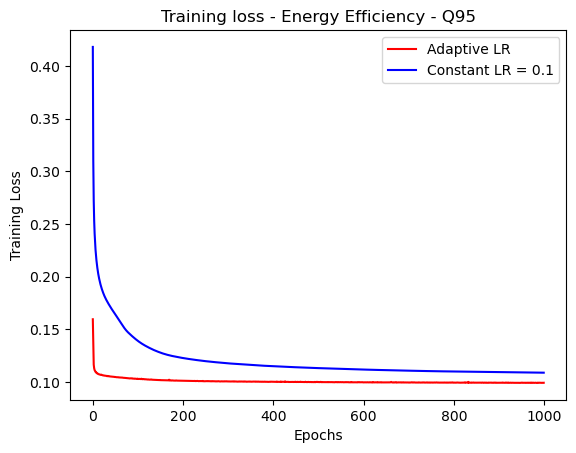

In [25]:
loss_adaptive = history_Q95.history['loss']
loss_constant = history_const_Q95.history['loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - Energy Efficiency - Q95')
plt.savefig('Training_Loss-Energy_Efficiency-Q95.png')
plt.legend()



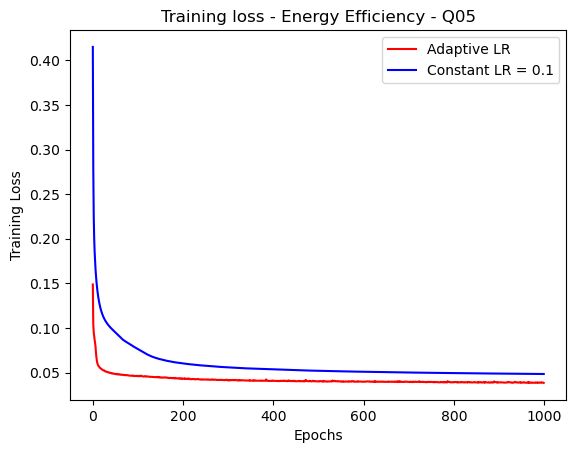

In [26]:
loss_adaptive = history_Q05.history['loss']
loss_constant = history_const_Q05.history['loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - Energy Efficiency - Q05')
plt.savefig('Training_Loss-Energy_Efficiency-Q05.png')
plt.legend()


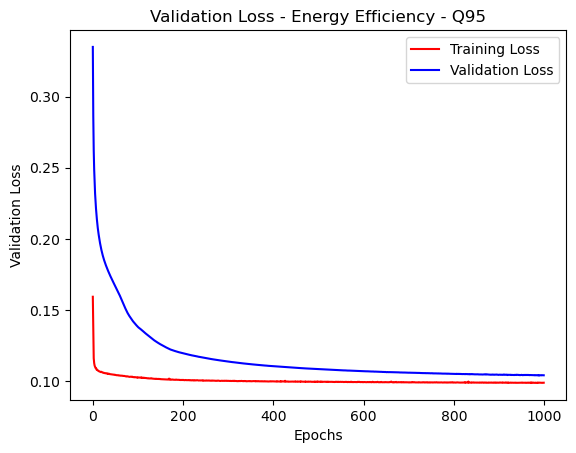

In [27]:

loss = history_Q95.history['loss']
val_loss = history_const_Q95.history['val_loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - Energy Efficiency - Q95')
plt.savefig('Validation_Loss-Energy_Efficiency-Q95-V.png')
plt.legend()


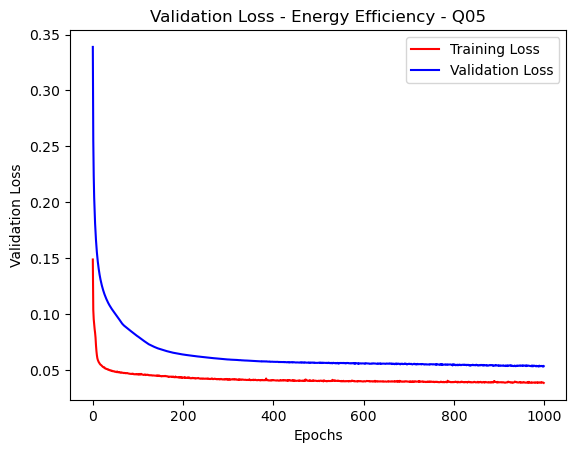

In [28]:

loss = history_Q05.history['loss']
val_loss = history_const_Q05.history['val_loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - Energy Efficiency - Q05')
plt.savefig('Validation_Loss-Energy_Efficiency-Q05-V.png')
plt.legend()